## The Reuters dataset

Classifying newswires: a multiclass classification example

You’ll work with the Reuters dataset, a set of short newswires and their topics, published
by Reuters in 1986. It’s a simple, widely used toy dataset for text classification. There
are 46 different topics; some topics are more represented than others, but each topic
has at least 10 examples in the training set.

In [1]:
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
num_words=10000)

Using TensorFlow backend.


In [2]:
#Decoding newswires back to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[0]])
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [3]:
train_data[0]

[1,
 2,
 2,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

In [4]:
#The label associated with an example is an integer between 0 and 45—a topic index:
train_labels[10]

3

In [5]:
#Encoding the data
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

#Vectorized training data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: you can cast the label list as an inte-
ger tensor, or you can use one-hot encoding. One-hot encoding is a widely used for-
mat for categorical data, also called categorical encoding

In [6]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [7]:
from keras.utils.np_utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In the IMDB example, you used 16-dimensional intermediate layers, but a 16-dimensional space may
be too limited to learn to separate 46 different classes: such small layers may act as infor-
mation bottlenecks, permanently dropping relevant information.
For this reason you’ll use larger layers. Let’s go with 64 units.

In [8]:
from keras import models
from keras import layers
#model = models.Sequential()
#model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(46, activation='softmax'))

from keras import regularizers
model = models.Sequential()
model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))

There are two other things you should note about this architecture:
    
* You end the network with a Dense layer of size 46. This means for each input
sample, the network will output a 46-dimensional vector. Each entry in this vec-
tor (each dimension) will encode a different output class.
* The last layer uses a softmax activation. You saw this pattern in the MNIST
example. It means the network will output a probability distribution over the 46
different output classes—for every input sample, the network will produce a 46-
dimensional output vector, where output[i] is the probability that the sample
belongs to class i . The 46 scores will sum to 1.

The best loss function to use in this case is categorical_crossentropy . It measures
the distance between two probability distributions: here, between the probability dis-
tribution output by the network and the true distribution of the labels. By minimizing
the distance between these two distributions, you train the network to output some-
thing as close as possible to the true labels.

In [9]:
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [10]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [11]:
history = model.fit(partial_x_train,
partial_y_train,
epochs=20,
batch_size=512,
validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 390us/step - loss: 15.6909 - acc: 0.4599 - val_loss: 6.2428 - val_acc: 0.5400
Epoch 2/20
7982/7982 [==============================] - 2s 273us/step - loss: 5.8119 - acc: 0.5672 - val_loss: 5.2896 - val_acc: 0.5670
Epoch 3/20
7982/7982 [==============================] - 2s 282us/step - loss: 5.0499 - acc: 0.6019 - val_loss: 4.6760 - val_acc: 0.6500
Epoch 4/20
7982/7982 [==============================] - 2s 282us/step - loss: 4.5335 - acc: 0.6193 - val_loss: 4.2128 - val_acc: 0.6530
Epoch 5/20
7982/7982 [==============================] - 2s 291us/step - loss: 4.1241 - acc: 0.6447 - val_loss: 3.8657 - val_acc: 0.6580
Epoch 6/20
7982/7982 [==============================] - 2s 288us/step - loss: 3.8179 - acc: 0.6501 - val_loss: 3.6958 - val_acc: 0.6850
Epoch 7/20
7982/7982 [==============================] - 2s 292us/step - loss: 3.6051 - acc: 0.6620 - val_loss: 3.4518 - val_acc: 0.6740

In [12]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

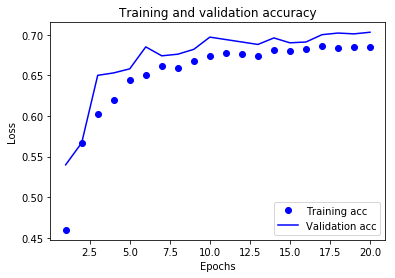

In [13]:
plt.clf()
#Clears the figure
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
results = model.evaluate(x_test, one_hot_test_labels)
results

2246/2246 [==============================] - 1s 406us/step


[3.014612325259011, 0.6861086375779163]

The network begins to overfit after nine epochs. Let’s train a new network from
scratch for nine epochs and then evaluate it on the test set

In [15]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(partial_x_train,
partial_y_train,
epochs=9,
batch_size=512,
validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 163us/step - loss: 2.5383 - acc: 0.5227 - val_loss: 1.6846 - val_acc: 0.6490
Epoch 2/9
7982/7982 [==============================] - 1s 123us/step - loss: 1.3794 - acc: 0.7107 - val_loss: 1.2821 - val_acc: 0.7200
Epoch 3/9
7982/7982 [==============================] - 1s 115us/step - loss: 1.0204 - acc: 0.7783 - val_loss: 1.1335 - val_acc: 0.7520
Epoch 4/9
7982/7982 [==============================] - 1s 116us/step - loss: 0.8024 - acc: 0.8250 - val_loss: 1.0555 - val_acc: 0.7600
Epoch 5/9
7982/7982 [==============================] - 1s 121us/step - loss: 0.6417 - acc: 0.8621 - val_loss: 0.9812 - val_acc: 0.7970
Epoch 6/9
7982/7982 [==============================] - 1s 124us/step - loss: 0.5138 - acc: 0.8930 - val_loss: 0.9120 - val_acc: 0.8120
Epoch 7/9
7982/7982 [==============================] - 1s 114us/step - loss: 0.4148 - acc: 0.9141 - val_loss: 0.8955 - val_acc: 0.8230
Epoch 8

In [16]:
results

[1.0225942767526248, 0.7778272484947504]

In [17]:
#Generating predictions for new data
predictions = model.predict(x_test)
#Each entry in predictions is a vector of length 46:
print(predictions[0].shape)

#The coefficients in this vector sum to 1:
print(np.sum(predictions[0]))

#The largest entry is the predicted class—the class with the highest probability:
print(np.argmax(predictions[0]))


(46,)
1.0000002
3


In [18]:
predictions.shape

(2246, 46)

In [19]:
x_test.shape

(2246, 10000)

## A different way to handle the labels and the loss

In [21]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)
#The only thing this approach would change is the choice of the loss function. The loss
#function used in listing 3.21, categorical_crossentropy , expects the labels to follow
#a categorical encoding. With integer labels, you should use sparse_categorical_
#crossentropy :
model.compile(optimizer='rmsprop',
loss='sparse_categorical_crossentropy',
metrics=['acc'])

## The importance of having sufficiently large intermediate layers

We mentioned earlier that because the final outputs are 46-dimensional, you should
avoid intermediate layers with many fewer than 46 hidden units. Now let’s see what
happens when you introduce an information bottleneck by having intermediate layers
that are significantly less than 46-dimensional: for example, 4-dimensional.

In [22]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(partial_x_train,
partial_y_train,
epochs=20,
batch_size=128,
validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 261us/step - loss: 3.1594 - acc: 0.2402 - val_loss: 2.5913 - val_acc: 0.2940
Epoch 2/20
7982/7982 [==============================] - 2s 201us/step - loss: 2.0399 - acc: 0.5537 - val_loss: 1.6958 - val_acc: 0.5850
Epoch 3/20
7982/7982 [==============================] - 2s 192us/step - loss: 1.4980 - acc: 0.6257 - val_loss: 1.5146 - val_acc: 0.6400
Epoch 4/20
7982/7982 [==============================] - 1s 187us/step - loss: 1.2881 - acc: 0.6931 - val_loss: 1.4181 - val_acc: 0.6730
Epoch 5/20
7982/7982 [==============================] - 2s 198us/step - loss: 1.1461 - acc: 0.7160 - val_loss: 1.3660 - val_acc: 0.6810
Epoch 6/20
7982/7982 [==============================] - 2s 203us/step - loss: 1.0414 - acc: 0.7315 - val_loss: 1.3453 - val_acc: 0.6950
Epoch 7/20
7982/7982 [==============================] - 2s 195us/step - loss: 0.9588 - acc: 0.7419 - val_loss: 1.3434 - val_acc: 0.6990


In [23]:
results = model.evaluate(x_test, one_hot_test_labels)
results

2246/2246 [==============================] - 0s 170us/step


[1.9532256251663793, 0.6883348174532502]

The network now peaks at ~71% validation accuracy, an 8% absolute drop. This drop
is mostly due to the fact that you’re trying to compress a lot of information (enough
information to recover the separation hyperplanes of 46 classes) into an intermediate
space that is too low-dimensional. The network is able to cram most of the necessary
information into these eight-dimensional representations, but not all of it.

Here’s what you should take away from this example:
* If you’re trying to classify data points among N classes, your network should end with a Dense layer of size N .
* In a single-label, multiclass classification problem, your network should end
with a softmax activation so that it will output a probability distribution over the
N output classes.
* Categorical crossentropy is almost always the loss function you should use for
such problems. It minimizes the distance between the probability distributions
output by the network and the true distribution of the targets.
* There are two ways to handle labels in multiclass classification:
- Encoding the labels via categorical encoding (also known as one-hot encod-
ing) and using categorical_crossentropy as a loss function
- Encoding the labels as integers and using the sparse_categorical_crossentropy
loss function
* If you need to classify data into a large number of categories, you should avoid
creating information bottlenecks in your network due to intermediate layers
that are too small.

## CONVOLUTIONAL NEURAL NETWORKS


### TEXT SEQUENCES

Here we explores deep-learning models that can process text (understood as
sequences of word or sequences of characters), timeseries, and sequence data in
general. The two fundamental deep-learning algorithms for sequence processing
are recurrent neural networks and **1D convnets**, the one-dimensional version of the 2D
convnets that we covered in the previous chapters. We’ll discuss both of these
approaches in this chapter.
Applications of these algorithms include the following:
* Document classification and timeseries classification, such as identifying the
topic of an article or the author of a book
* Timeseries comparisons, such as estimating how closely related two docu-
ments or two stock tickers are

* Sequence-to-sequence learning, such as decoding an English sentence into
French
* Sentiment analysis, such as classifying the sentiment of tweets or movie reviews
as positive or negative
* Timeseries forecasting, such as predicting the future weather at a certain loca-
tion, given recent weather data

## Working with text data
Text is one of the most widespread forms of sequence data. It can be understood as
either a sequence of characters or a sequence of words, but it’s most common to work
at the level of words

wE can use text to produce a basic form of natural-language under-
standing, sufficient for applications including document classification, sentiment
analysis, author identification, and even question-answering ( QA ) (in a constrained
context).

**Vectorizing** text is the process of transforming text
into numeric tensors. This can be done in multiple ways:
* Segment text into words, and transform each word into a vector.
* Segment text into characters, and transform each character into a vector.
* Extract n-grams of words or characters, and transform each n-gram into a vector.
N -grams are overlapping groups of multiple consecutive words or characters.

Collectively, the different units into which you can break down text (words, charac-
ters, or n-grams) are called **tokens**, and breaking text into such tokens is called **tokenization**

All text-vectorization processes consist of applying some tokenization scheme and
then associating numeric vectors with the generated tokens. These vectors, packed
into sequence tensors, are fed into deep neural networks. There are multiple ways to
associate a vector with a token. In this section, I’ll present two major ones: **one-hot
encoding of tokens**, and **token embedding** (typically used exclusively for words, and called
word embedding).

### Understanding n-grams and bag-of-words
Word n-grams are groups of N (or fewer) consecutive words that you can extract from
a sentence. The same concept may also be applied to characters instead of words.
Here’s a simple example. Consider the sentence “The cat sat on the mat.” It may be
decomposed into the following set of 2-grams:

    {"The", "The cat", "cat", "cat sat", "sat",
"sat on", "on", "on the", "the", "the mat", "mat"}

It may also be decomposed into the following set of 3-grams:

    {"The", "The cat", "cat", "cat sat", "The cat sat",
"sat", "sat on", "on", "cat sat on", "on the", "the",
"sat on the", "the mat", "mat", "on the mat"}

    Such a set is called a bag-of-2-grams or bag-of-3-grams, respectively. The term bag
here refers to the fact that you’re dealing with a set of tokens rather than a list or
sequence: the tokens have no specific order. This family of tokenization methods is
called **bag-of-words**.

Because bag-of-words isn’t an order-preserving tokenization method (the tokens gen-
erated are understood as a set, not a sequence, and the general structure of the sen-
tences is lost), it tends to be used in shallow language-processing models rather than
in deep-learning models. Extracting n-grams is a form of feature engineering, and
deep learning does away with this kind of rigid, brittle approach, replacing it with hier-
archical feature learning. One-dimensional convnets and recurrent neural networks, are capable of learning representations for groups of
words and characters without being explicitly told about the existence of such groups,
by looking at continuous word or character sequences.

## One-hot encoding of words and characters
One-hot encoding is the most common, most basic way to turn a token into a vector.
You saw it in action in the initial IMDB and Reuters examples(done with
words, in that case). It consists of associating a unique integer index with every word
and then turning this integer index i into a binary vector of size N (the size of the
vocabulary); the vector is all zeros except for the i th entry, which is 1.
Of course, one-hot encoding can be done at the character level, as well.

A variant of one-hot encoding is the so-called one-hot hashing trick, which you can use
when the number of unique tokens in your vocabulary is too large to handle explicitly. Instead of explicitly assigning an index to each word and keeping a reference of these
indices in a dictionary, you can hash words into vectors of fixed size.

In [24]:
import numpy as np
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
dimensionality = 1000
max_length = 10
results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

## Using word embeddings
Another popular and powerful way to associate a vector with a word is the use of dense
word vectors, also called word embeddings. Whereas the vectors obtained through one-hot
encoding are binary, sparse (mostly made of zeros), and very high-dimensional (same
dimensionality as the number of words in the vocabulary), word embeddings are low-
dimensional floating-point vectors (that is, dense vectors, as opposed to sparse vec-
tors);

There are two ways to obtain word embeddings:
* Learn word embeddings jointly with the main task you care about (such as doc-
ument classification or sentiment prediction). In this setup, you start with ran-
dom word vectors and then learn word vectors in the same way you learn the
weights of a neural network.
* Load into your model word embeddings that were precomputed using a differ-
ent machine-learning task than the one you’re trying to solve. These are called
pretrained word embeddings.

## Embedding layer
`from keras.layers import Embedding
embedding_layer = Embedding(1000, 64) # looking at the first 64 words in every review. `

Dense layer on top leads to a model that
treats each word in the input sequence separately, without considering inter-word
relationships and sentence structure (for example, this model would likely treat both
“this movie is a bomb” and “this movie is the bomb” as being negative reviews). It’s
much better to add recurrent layers or 1D convolutional layers on top of the embed-
ded sequences to learn features that take into account each sequence as a whole.
That’s what we’ll focus on in the next few sections.

## USING PRETRAINED WORD EMBEDDINGS
Sometimes, you have so little training data available that you can’t use your data
alone to learn an appropriate task-specific embedding of your vocabulary. What do
you do then?

There are various precomputed databases of word embeddings that you can down-
load and use in a Keras Embedding layer. Word2vec is one of them. Another popular
one is called Global Vectors for Word Representation (GloVe, https://nlp.stanford
.edu/projects/glove), which was developed by Stanford researchers in 2014.

## Understanding recurrent neural networks

A major characteristic of all neural networks you’ve seen so far, such as densely con-
nected networks and convnets, is that they have no memory. Each input shown to
them is processed independently, with no state kept in between inputs. With such net-
works, in order to process a sequence or a temporal series of data points, you have to
show the entire sequence to the network at once: turn it into a single data point. For
instance, this is what you did in the IMDB example: an entire movie review was trans-
formed into a single large vector and processed in one go. Such networks are called
feedforward networks.


## Understanding the LSTM and GRU layers
SimpleRNN isn’t the only recurrent layer available in Keras. There are two others: LSTM
and GRU . In practice, you’ll always use one of these, because SimpleRNN is generally too
simplistic to be of real use. SimpleRNN has a major issue: although it should theoretically
be able to retain at time t information about inputs seen many timesteps before, in
practice, such long-term dependencies are impossible to learn. This is due to the van-
ishing gradient problem, an effect that is similar to what is observed with non-recurrent
networks (feedforward networks) that are many layers deep: as you keep adding layers
to a network, the network eventually becomes untrainable. The theoretical reasons for
this effect were studied by Hochreiter, Schmidhuber, and Bengio in the early 1990s. 2

The LSTM and GRU layers are designed to solve this problem.

Let’s consider the LSTM layer. The underlying Long Short-Term Memory ( LSTM )
algorithm was developed by Hochreiter and Schmidhuber in 1997; 3 it was the culmi-
nation of their research on the vanishing gradient problem.

This layer is a variant of the SimpleRNN layer you already know about; it adds a way
to carry information across many timesteps. Imagine a conveyor belt running parallel
to the sequence you’re processing. Information from the sequence can jump onto the
conveyor belt at any point, be transported to a later timestep, and jump off, intact,
when you need it. This is essentially what LSTM does: it saves information for later,
thus preventing older signals from gradually vanishing during processing.

**Just keep in mind what the LSTM cell is meant to do: allow past informa-
tion to be reinjected at a later time, thus fighting the vanishing-gradient problem.**

## A temperature-forecasting problem (NO FUNCIONA --> IR A TIME SERIES)

You have access to a timeseries of data points coming from sensors installed on
the roof of a building, such as temperature, air pressure, and humidity, which you use
to predict what the temperature will be 24 hours after the last data point. This is a
fairly challenging problem that exemplifies many common difficulties encountered
when working with timeseries.

We’ll cover the following techniques:

* Recurrent dropout—This is a specific, built-in way to use dropout to fight overfit-
ting in recurrent layers.
* **Stacking recurrent layers**—This increases the representational power of the net-
work (at the cost of higher computational loads).
* Bidirectional recurrent layers—These present the same information to a recurrent
network in different ways, increasing accuracy and mitigating forgetting issues.

In this dataset, 14 different quantities (such air temperature, atmospheric pres-
sure, humidity, wind direction, and so on) were recorded every 10 minutes, over sev-
eral years. The original data goes back to 2003, but this example is limited to data
from 2009–2016. This dataset is perfect for learning to work with numerical
timeseries. You’ll use it to build a model that takes as input some data from the recent
past (a few days’ worth of data points) and predicts the air temperature 24 hours in
the future

`cd ~/Downloads
mkdir jena_climate
cd jena_climate
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
unzip jena_climate_2009_2016.csv.zip`

In [1]:
import os
data_dir = '/home/erikapat/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
lines

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60',
 '01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00',
 '01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30',
 '01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70',
 '01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50',
 '01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.40,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.60',
 '01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.80,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.50',
 '01.01.2009 01:40:00,996.53,-8.43,264.99,-9.3

In [3]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1] #<1> temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

Here is a more narrow plot of the first 10 days of temperature data.
Because the data is recorded every 10 minutes, you get 144 data points per day.

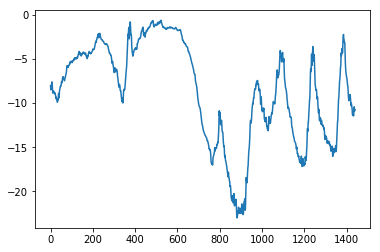

In [5]:
plt.plot(range(1440), temp[:1440])

On this plot, you can see daily periodicity, especially evident for the last 4 days. Also
note that this 10-day period must be coming from a fairly cold winter month.

If you were trying to predict average temperature for the next month given a few
months of past data, the problem would be easy, due to the reliable year-scale period-
icity of the data.

The exact formulation of the problem will be as follows: given data going as far back
as lookback timesteps (a timestep is 10 minutes) and sampled every steps timesteps,
can you predict the temperature in delay timesteps? You’ll use the following parame-
ter values:
* lookback = 720 —Observations will go back 5 days.
* steps = 6 —Observations will be sampled at one data point per hour.
* delay = 144 —Targets will be 24 hours in the future.

To get started, you need to do two things:
    
* Preprocess the data to a format a neural network can ingest. This is easy: the
data is already numerical, so you don’t need to do any vectorization. But each
timeseries in the data is on a different scale (for example, temperature is typi-
cally between -20 and +30, but atmospheric pressure, measured in mbar, is
around 1,000). You’ll normalize each timeseries independently so that they all
take small values on a similar scale.
* Write a Python generator that takes the current array of float data and yields
batches of data from the recent past, along with a target temperature in the
future. Because the samples in the dataset are highly redundant (sample N and
sample N + 1 will have most of their timesteps in common), it would be wasteful
to explicitly allocate every sample. Instead, you’ll generate the samples on the
fly using the original data.

You’ll preprocess the data by subtracting the mean of each timeseries and dividing by
the standard deviation. You’re going to use the first 200,000 timesteps as training data,
so compute the mean and standard deviation only on this fraction of the data.

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

* data —The original array of floating-point data, which you normalized in listing 6.32.
* lookback —How many timesteps back the input data should go.
* delay —How many timesteps in the future the target should be.
* min_index and max_index —Indices in the data array that delimit which time-
steps to draw from. This is useful for keeping a segment of the data for valida-
tion and another for testing.
* shuffle —Whether to shuffle the samples or draw them in chronological order.
* batch_size —The number of samples per batch.
* step —The period, in timesteps, at which you sample data. You’ll set it to 6 in
order to draw one data point every hour.

In [7]:
#Generator yielding timeseries samples and their targets
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

In [8]:
##Preparing the training, validation, and test generators
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=200000,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                            lookback=lookback,
                            delay=delay,
                            min_index=300001,
                            max_index=None,
                            step=step,
                            batch_size=batch_size)
#How many steps to draw from val_gen in order to see the
#entire validation set
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [9]:
val_steps

98559

## A common-sense, non-machine-learning baseline

Before you start using black-box deep-learning models to solve the temperature-
prediction problem, let’s try a simple, common-sense approach. It will serve as a sanity
check, and it will establish a baseline that you’ll have to beat in order to demonstrate
the usefulness of more-advanced machine-learning models. Such common-sense base-
lines can be useful when you’re approaching a new problem for which there is no
known solution (yet). A classic example is that of unbalanced classification tasks,
where some classes are much more common than others. If your dataset contains 90%
instances of class A and 10% instances of class B, then a common-sense approach to
the classification task is to always predict “A” when presented with a new sample. Such
a classifier is 90% accurate overall, and any learning-based approach should therefore
beat this 90% score in order to demonstrate usefulness. Sometimes, such elementary
baselines can prove surprisingly hard to beat.

In this case, the temperature timeseries can safely be assumed to be continuous
(the temperatures tomorrow are likely to be close to the temperatures today) as well
as periodical with a daily period. Thus a common-sense approach is to always predict
that the temperature 24 hours from now will be equal to the temperature right now.

In [10]:
samples, targets = next(val_gen)

In [11]:
print(samples.shape)
print(targets.shape)

(128, 240, 14)
(128,)


In [10]:
##Computing the common-sense baseline MAE
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    

In [ ]:
evaluate_naive_method()

This yields an MAE of 0.29. Because the temperature data has been normalized to be
centered on 0 and have a standard deviation of 1, this number isn’t immediately inter-
pretable. It translates to an average absolute error of 0.29 × temperature_std degrees
Celsius: 2.57 ̊C.

## A basic machine-learning approach
In the same way that it’s useful to establish a common-sense baseline before trying
machine-learning approaches, it’s useful to try simple, cheap machine-learning mod-
els (such as small, densely connected networks) before looking into complicated and
computationally expensive models such as RNN s. This is the best way to make sure any
further complexity you throw at the problem is legitimate and delivers real benefits.

The following listing shows a fully connected model that starts by flattening the
data and then runs it through two Dense layers. Note the lack of activation function on
the last Dense layer, which is typical for a regression problem. You use MAE as the loss.
Because you evaluate on the exact same data and with the exact same metric you did
with the common-sense approach, the results will be directly comparable.

In [ ]:
##Training and evaluating a densely connected model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                                epochs=20,
                                validation_data=val_gen,
                                validation_steps=val_steps)

Using TensorFlow backend.


In [ ]:
##Plotting results
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Some of the validation losses are close to the no-learning baseline, but not reliably.
This goes to show the merit of having this baseline in the first place: it turns out to be
not easy to outperform. Your common sense contains a lot of valuable information
that a machine-learning model doesn’t have access to.

You may wonder, if a simple, well-performing model exists to go from the data to
the targets (the common-sense baseline), why doesn’t the model you’re training find it
and improve on it? Because this simple solution isn’t what your training setup is look-
ing for. The space of models in which you’re searching for a solution—that is, your
hypothesis space—is the space of all possible two-layer networks with the configuration
you defined. These networks are already fairly complicated. When you’re looking for a
solution with a space of complicated models, the simple, well-performing baseline may
be unlearnable, even if it’s technically part of the hypothesis space. That is a pretty sig-
nificant limitation of machine learning in general: unless the learning algorithm is
hardcoded to look for a specific kind of simple model, parameter learning can some-
times fail to find a simple solution to a simple problem.

## A first recurrent baseline
The previous approach first flattened the
timeseries, which removed the notion of time from the input data. Let’s instead look
at the data as what it is: a sequence, where causality and order matter. You’ll try a
recurrent-sequence processing model—it should be the perfect fit for such sequence
data, precisely because it exploits the temporal ordering of data points, unlike the first
approach.
Instead of the LSTM layer introduced in the previous section, you’ll use the GRU
layer, developed by Chung et al. in 2014. 5 **Gated recurrent unit ( GRU )** layers work
using the same principle as LSTM , but they’re somewhat streamlined and thus
cheaper to run (although they may not have as much representational power as
LSTM ). This trade-off between computational expensiveness and representational
power is seen everywhere in machine learning.

In [ ]:
## Training and evaluating a GRU-based model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                                epochs=20,
                                validation_data=val_gen,
                                validation_steps=val_steps)

Much better! You can significantly beat the common-
sense baseline, demonstrating the value of machine learning as well as the superiority
of recurrent networks compared to sequence-flattening dense networks on this type
of task.

The new validation MAE of ~0.265 (before you start significantly overfitting) translates
to a mean absolute error of 2.35 ̊C after denormalization. That’s a solid gain on the
initial error of 2.57 ̊C, but you probably still have a bit of a margin for improvement.

## Using recurrent dropout to fight overfitting

In order to regularize the representations formed by the recurrent gates
of layers such as GRU and LSTM , a temporally constant dropout mask should be applied
to the inner recurrent activations of the layer (a recurrent dropout mask). Using the
same dropout mask at every timestep allows the network to properly propagate its
learning error through time; a temporally random dropout mask would disrupt this
error signal and be harmful to the learning process.
Yarin Gal did his research using Keras and helped build this mechanism directly
into Keras recurrent layers. Every recurrent layer in Keras has two dropout-related
arguments: dropout , a float specifying the dropout rate for input units of the layer,
    and recurrent_dropout , specifying the dropout rate of the recurrent units. Let’s add
dropout and recurrent dropout to the GRU layer and see how doing so impacts overfit-
ting. Because networks being regularized with dropout always take longer to fully con-
verge, you’ll train the network for twice as many epochs.

In [ ]:
#Training and evaluating a dropout-regularized GRU-based model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
dropout=0.2,
recurrent_dropout=0.2,
input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=40,
                            validation_data=val_gen,
                            validation_steps=val_steps)

## Stacking recurrent layers
Because you’re no longer overfitting but seem to have hit a performance bottleneck,
you should consider increasing the capacity of the network. Recall the description of
the universal machine-learning workflow: it’s generally a good idea to increase the
capacity of your network until overfitting becomes the primary obstacle (assuming
you’re already taking basic steps to mitigate overfitting, such as using dropout). As
long as you aren’t overfitting too badly, you’re likely under capacity.
Increasing network capacity is typically done by increasing the number of units in
the layers or adding more layers. Recurrent layer stacking is a classic way to build
more-powerful recurrent networks: for instance, what currently powers the Google
Translate algorithm is a stack of seven large LSTM layers—that’s huge.
To stack recurrent layers on top of each other in Keras, all intermediate layers
should return their full sequence of outputs (a 3D tensor) rather than their output at
the last timestep. This is done by specifying return_sequences=True

In [ ]:
##Training and evaluating a dropout-regularized, stacked GRU model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
dropout=0.1,
recurrent_dropout=0.5,
return_sequences=True,
input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
dropout=0.1,
recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=40,
validation_data=val_gen,
validation_steps=val_steps)

* Because you’re still not overfitting too badly, you could safely increase the size of
your layers in a quest for validation-loss improvement. This has a non-negligible
computational cost, though.
* Adding a layer didn’t help by a significant factor, so you may be seeing diminish-
ing returns from increasing network capacity at this point.

## Using bidirectional RNNs

RNN s are notably order dependent, or time dependent: they process the timesteps
of their input sequences in order, and shuffling or reversing the timesteps can com-
pletely change the representations the RNN extracts from the sequence. This is pre-
cisely the reason they perform well on problems where order is meaningful, such as
the temperature-forecasting problem. A bidirectional RNN exploits the order sensitiv-
ity of RNN s: it consists of using two regular RNN s, such as the GRU and LSTM layers
you’re already familiar with, each of which processes the input sequence in one direc-
tion (chronologically and antichronologically), and then merging their representa-
tions. By processing a sequence both ways, a bidirectional RNN can catch patterns that
may be overlooked by a unidirectional RNN .

Remarkably, the fact that the RNN layers in this section have processed sequences in
chronological order (older timesteps first) may have been an arbitrary decision. At least,
it’s a decision we made no attempt to question so far. Could the RNN s have performed
well enough if they processed input sequences in antichronological order, for instance
(newer timesteps first)? Let’s try this in practice and see what happens. All you need to
do is write a variant of the data generator where the input sequences are reverted along
the time dimension (replace the last line with yield samples[:, ::-1, :], targets ).

The underlying GRU layer will typically be better at
remembering the recent past than the distant past, and naturally the more recent
weather data points are more predictive than older data points for the problem (that’s
what makes the common-sense baseline fairly strong). Thus the chronological version
of the layer is bound to outperform the reversed-order version. Importantly, this isn’t
true for many other problems, including natural language: intuitively, the importance
of a word in understanding a sentence isn’t usually dependent on its position in the sen-
tence.

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential


max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(
num_words=max_features)
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(x_train, y_train,
epochs=10,
batch_size=128,
validation_split=0.2)

You get performance nearly identical to that of the chronological-order LSTM .
Remarkably, on such a text dataset, reversed-order processing works just as well as
chronological processing, confirming the hypothesis that, although word order does
matter in understanding language, which order you use isn’t crucial. Importantly, an
RNN trained on reversed sequences will learn different representations than one
trained on the original sequences, much as you would have different mental models if
time flowed backward in the real world—if you lived a life where you died on your first
day and were born on your last day. In machine learning, representations that are dif-
ferent yet useful are always worth exploiting, and the more they differ, the better: they
offer a new angle from which to look at your data, capturing aspects of the data that
were missed by other approaches, and thus they can help boost performance on a
task. This is the intuition behind ensembling, a concept we’ll explore in chapter 7.
A bidirectional RNN exploits this idea to improve on the performance of chronological-
order RNNs.

To instantiate a bidirectional RNN in Keras, you use the Bidirectional layer, which takes
as its first argument a recurrent layer instance. Bidirectional creates a second, separate
instance of this recurrent layer and uses one instance for processing the input sequences
in chronological order and the other instance for processing the input sequences in
reversed order. Let’s try it on the IMDB sentiment-analysis task.

In [ ]:
#Training and evaluating a bidirectional LSTM
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=128,
validation_split=0.2)

It performs slightly better than the regular LSTM you tried in the previous section,
achieving over 89% validation accuracy. It also seems to overfit more quickly, which is
unsurprising because a bidirectional layer has twice as many parameters as a chrono-
logical LSTM . With some regularization, the bidirectional approach would likely be a
strong performer on this task.
Now let’s try the same approach on the temperature-prediction task.

In [ ]:
##Training a bidirectional GRU
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Bidirectional(
layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=40,
validation_data=val_gen,
validation_steps=val_steps)

This performs about as well as the regular GRU layer. It’s easy to understand why: all the
predictive capacity must come from the chronological half of the network, because the
antichronological half is known to be severely underperforming on this task (again,
because the recent past matters much more than the distant past in this case).

## Going even further
There are many other things you could try, in order to improve performance on the
temperature-forecasting problem:
* Adjust the number of units in each recurrent layer in the stacked setup. The
current choices are largely arbitrary and thus probably suboptimal.
* Adjust the learning rate used by the RMSprop optimizer.
* Try using LSTM layers instead of GRU layers.
* Try using a bigger densely connected regressor on top of the recurrent layers:
that is, a bigger Dense layer or even a stack of Dense layers.
* Don’t forget to eventually run the best-performing models (in terms of valida-
tion MAE ) on the test set! Otherwise, you’ll develop architectures that are over-
fitting to the validation set

As always, **deep learning is more an art than a science**. We can provide guidelines that
suggest what is likely to work or not work on a given problem, but, ultimately, every
problem is unique; you’ll have to evaluate different strategies empirically. There is
currently no theory that will tell you in advance precisely what you should do to opti-
mally solve a problem. You must iterate.

## Wrapping up
Here’s what you should take away from this section:
* As you first learned in chapter 4, when approaching a new problem, it’s good to
first establish common-sense baselines for your metric of choice. If you don’t
have a baseline to beat, you can’t tell whether you’re making real progress.
* Try simple models before expensive ones, to justify the additional expense.
Sometimes a simple model will turn out to be your best option.
* When you have data where temporal ordering matters, recurrent networks are
a great fit and easily outperform models that first flatten the temporal data.
* To use dropout with recurrent networks, you should use a time-constant drop-
out mask and recurrent dropout mask. These are built into Keras recurrent lay-
ers, so all you have to do is use the dropout and recurrent_dropout arguments
of recurrent layers.
* Stacked RNN s provide more representational power than a single RNN layer.
They’re also much more expensive and thus not always worth it. Although they
offer clear gains on complex problems (such as machine translation), they may
not always be relevant to smaller, simpler problems.
* Bidirectional RNN s, which look at a sequence both ways, are useful on natural-
language processing problems. But they aren’t strong performers on sequence
data where the recent past is much more informative than the beginning of the
sequence.

### NOTE
There are two important concepts we won’t cover in detail here: recur-
rent attention and sequence masking. Both tend to be especially relevant for
natural-language processing, and they aren’t particularly applicable to the
temperature-forecasting problem. We’ll leave them for future study outside of
this book.


## SEQUENCE PROCESSING WITH COVNETS P.238